<a href="https://colab.research.google.com/github/samitroy-utexas/AI395T/blob/main/ML_DL_sr56764.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost
!pip install nltk

# **Predicting In-Hospital Mortality Using MIMIC-III Data** *by Samit Roy*

# **Data Preprocessing**

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import nltk
from nltk import word_tokenize
import string

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_curve, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
import xgboost
from xgboost import XGBClassifier

# Google Colab
from google.colab import files

# Download the 'punkt_tab' data package
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Data Cleaning and Feature Engineering**

In [ ]:
# Connect to Google Drive to read in the files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the data
df = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/ADMISSIONS.csv', low_memory=False).set_index('ROW_ID')
df_icu = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/ICUSTAYS.csv', low_memory=False).set_index('ROW_ID')
df_pat = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/PATIENTS.csv', low_memory=False).set_index('ROW_ID')
df_diagcode = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv', low_memory=False).set_index('ROW_ID')
df_icd_diagnoses = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv', low_memory=False).set_index('ROW_ID')
df_discharge_summary = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/all_discharge_summary.csv', low_memory=False).set_index('ROW_ID')

Mounted at /content/drive


In [ ]:
# Drop unnecessary columns
df.drop(columns=['DISCHTIME', 'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'], inplace=True)

# Create a boolean column for in-hospital deaths
df['DECEASED_IN_HOSPITAL'] = df['DEATHTIME'].notnull().map({True:1, False:0})


DECEASED_IN_HOSPITAL
0    53122
1     5854
Name: count, dtype: int64


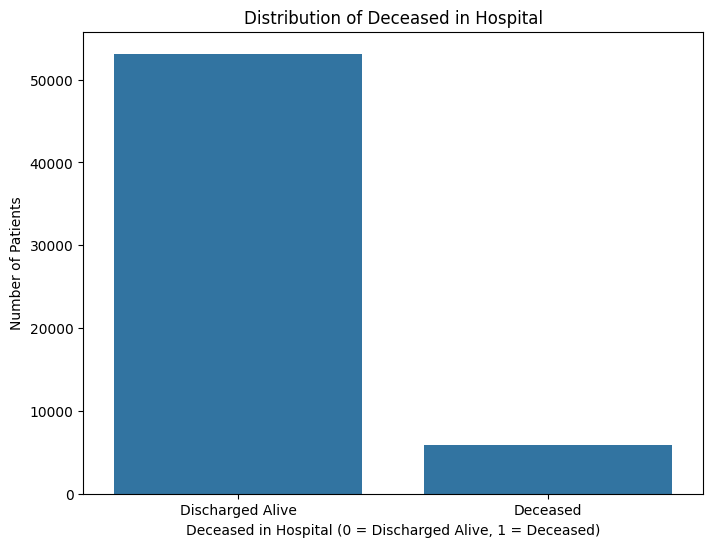

In [ ]:
# Check and plot unique values in DECEASED_IN_HOSPITAL column
expire_counts = df['DECEASED_IN_HOSPITAL'].value_counts()

# Print out the counts for a quick check
print(expire_counts)

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='DECEASED_IN_HOSPITAL', data=df)
plt.title('Distribution of Deceased in Hospital')
plt.xlabel('Deceased in Hospital (0 = Discharged Alive, 1 = Deceased)')
plt.ylabel('Number of Patients')
plt.xticks([0, 1], ['Discharged Alive', 'Deceased'])
plt.show()

In [ ]:
# Convert admission and death times to datetime
df.ADMITTIME = pd.to_datetime(df.ADMITTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df.DEATHTIME = pd.to_datetime(df.DEATHTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Sort by SUBJECT_ID and admission date
df = df.sort_values(['SUBJECT_ID', 'ADMITTIME']).reset_index(drop=True)

# Create a binary label for ICU admission: 1 if admitted to ICU, 0 otherwise
df['ICU_ADMISSION'] = df['HADM_ID'].isin(df_icu['HADM_ID']).astype(int)

# Check for missing dates
print('Number of missing admission dates:', df.ADMITTIME.isnull().sum())


Number of missing admission dates: 0


In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED_IN_HOSPITAL,ICU_ADMISSION
0,2,163353,2138-07-17 19:04:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NEWBORN,0,1
1,3,145834,2101-10-20 19:08:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,HYPOTENSION,0,1
2,4,185777,2191-03-16 00:28:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,5,178980,2103-02-02 04:31:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NEWBORN,0,1
4,6,107064,2175-05-30 07:15:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHRONIC RENAL FAILURE/SDA,0,1


ICU Admission Distribution:
ICU_ADMISSION
1    57786
0     1190
Name: count, dtype: int64


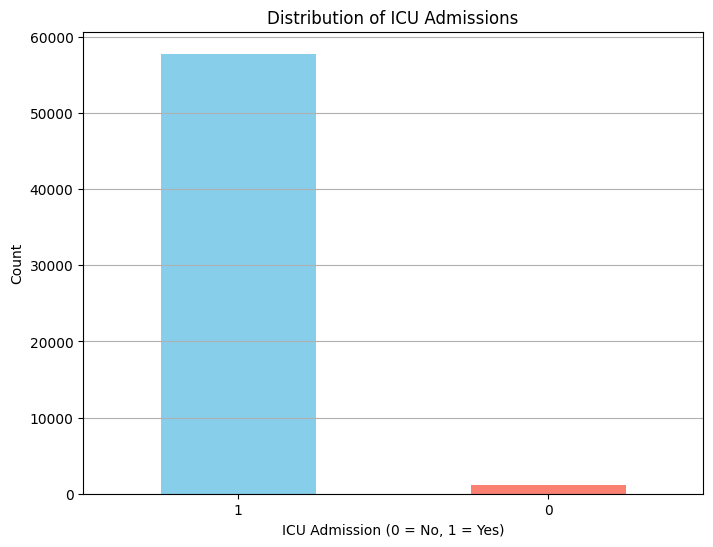

In [ ]:
# Plot and check distribution of ICU admissions
icu_counts = df['ICU_ADMISSION'].value_counts()
print("ICU Admission Distribution:")
print(icu_counts)

# Plot the distribution
plt.figure(figsize=(8, 6))
icu_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of ICU Admissions')
plt.xlabel('ICU Admission (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [ ]:
df_icu.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
ROW_ID,,,,,,,,,,,
365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [ ]:
# Aggregate and merge ICU stays data
icu_aggregated = df_icu.groupby('HADM_ID', as_index=False).agg({'LOS': 'sum'})

# Merge aggregated ICU stays data with df
df = pd.merge(df, icu_aggregated, on='HADM_ID', how='left')

# Display the resulting DataFrame
list(df)

print(df)

len(df)

       SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE  \
0               2   163353 2138-07-17 19:04:00       NaT        NEWBORN   
1               3   145834 2101-10-20 19:08:00       NaT      EMERGENCY   
2               4   185777 2191-03-16 00:28:00       NaT      EMERGENCY   
3               5   178980 2103-02-02 04:31:00       NaT        NEWBORN   
4               6   107064 2175-05-30 07:15:00       NaT       ELECTIVE   
...           ...      ...                 ...       ...            ...   
58971       99985   176670 2181-01-27 02:47:00       NaT      EMERGENCY   
58972       99991   151118 2184-12-24 08:30:00       NaT       ELECTIVE   
58973       99992   197084 2144-07-25 18:03:00       NaT      EMERGENCY   
58974       99995   137810 2147-02-08 08:00:00       NaT       ELECTIVE   
58975       99999   113369 2117-12-30 07:15:00       NaT       ELECTIVE   

              ADMISSION_LOCATION         DISCHARGE_LOCATION INSURANCE  \
0      PHYS REFERRAL/NORMA

58976

In [ ]:
# Inspect the data
pd.set_option('display.max_colwidth', None)  # Display full column width
pd.set_option('display.max_columns', None)
print(df.head())

   SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE  \
0           2   163353 2138-07-17 19:04:00       NaT        NEWBORN   
1           3   145834 2101-10-20 19:08:00       NaT      EMERGENCY   
2           4   185777 2191-03-16 00:28:00       NaT      EMERGENCY   
3           5   178980 2103-02-02 04:31:00       NaT        NEWBORN   
4           6   107064 2175-05-30 07:15:00       NaT       ELECTIVE   

          ADMISSION_LOCATION         DISCHARGE_LOCATION INSURANCE LANGUAGE  \
0  PHYS REFERRAL/NORMAL DELI                       HOME   Private      NaN   
1       EMERGENCY ROOM ADMIT                        SNF  Medicare      NaN   
2       EMERGENCY ROOM ADMIT  HOME WITH HOME IV PROVIDR   Private      NaN   
3  PHYS REFERRAL/NORMAL DELI                       HOME   Private      NaN   
4  PHYS REFERRAL/NORMAL DELI           HOME HEALTH CARE  Medicare     ENGL   

            RELIGION MARITAL_STATUS ETHNICITY  \
0      NOT SPECIFIED            NaN     ASIAN   
1     

In [ ]:
# Inspect how many died in the hospital
print("{} of {} patients died in the hospital".format(df['DECEASED_IN_HOSPITAL'].sum(),
                                                     df['SUBJECT_ID'].nunique()))

df['DECEASED_IN_HOSPITAL'][df['DECEASED_IN_HOSPITAL']== 1].describe()

# Drop negative ICU Length of Stays (LOS)
df = df[df['LOS'] > 0]

# Look at statistics less admissions resulting in death
df['LOS'].loc[df['DECEASED_IN_HOSPITAL'] == 0].describe()

# Hospital LOS metrics
actual_mean_los = df['LOS'].loc[df['DECEASED_IN_HOSPITAL'] == 0].mean()
actual_median_los = df['LOS'].loc[df['DECEASED_IN_HOSPITAL'] == 0].median()

print(actual_mean_los)
print(actual_median_los)


5854 of 46520 patients died in the hospital
5.0640430490339465
2.0801999999999996


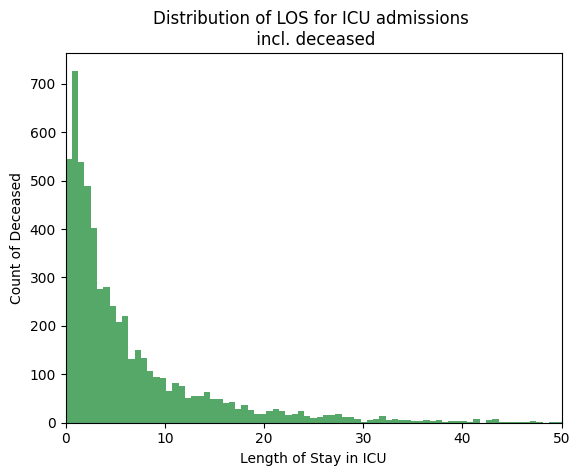

In [ ]:
# Plot the distribution of LOS in ICUs with Deceased
plt.hist(df['LOS'].loc[df['DECEASED_IN_HOSPITAL'] == 1], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for ICU admissions \n incl. deceased')
plt.ylabel('Count of Deceased')
plt.xlabel('Length of Stay in ICU')
plt.tick_params(top=False, right=False)
plt.show();


In [ ]:
list(df)

['SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DEATHTIME',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'DIAGNOSIS',
 'DECEASED_IN_HOSPITAL',
 'ICU_ADMISSION',
 'LOS']

In [ ]:
df['DECEASED_IN_HOSPITAL'][df['DECEASED_IN_HOSPITAL']== 1].describe()


,DECEASED_IN_HOSPITAL
count,5812.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [ ]:
df[df['DECEASED_IN_HOSPITAL']==1].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED_IN_HOSPITAL,ICU_ADMISSION,LOS
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,NaN,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,1,1,5.3231
10,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,NaN,JEWISH,MARRIED,WHITE,PANCREATIC CANCER/SDA,1,1,7.6348
19,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,MARRIED,WHITE,SEPSIS,1,1,8.3647
29,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,STATUS EPILEPTICUS,1,1,7.9379
54,56,181711,2104-01-02 02:01:00,2104-01-08 10:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,NOT SPECIFIED,NaN,WHITE,HEAD BLEED,1,1,1.8492


In [ ]:
# Look at statistics of admissions resulting in death
df['LOS'].loc[df['DECEASED_IN_HOSPITAL'] == 1].describe()

,LOS
count,5812.000000
mean,6.781747
std,9.052548
min,0.000200
25%,1.467750
50%,3.625850
75%,8.318625
max,126.501500


In [ ]:
df['ETHNICITY'].value_counts()

,count
ETHNICITY,
WHITE,40107
BLACK/AFRICAN AMERICAN,5327
UNKNOWN/NOT SPECIFIED,4478
HISPANIC OR LATINO,1671
OTHER,1482
ASIAN,1456
UNABLE TO OBTAIN,814
PATIENT DECLINED TO ANSWER,548
ASIAN - CHINESE,268


In [ ]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

<ipython-input-19-3a5f49e66dcd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
<ipython-input-19-3a5f49e66dcd>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

,count
ETHNICITY,
WHITE,40431
OTHER/UNKNOWN,7644
BLACK/AFRICAN AMERICAN,5669
HISPANIC/LATINO,2092
ASIAN,1940


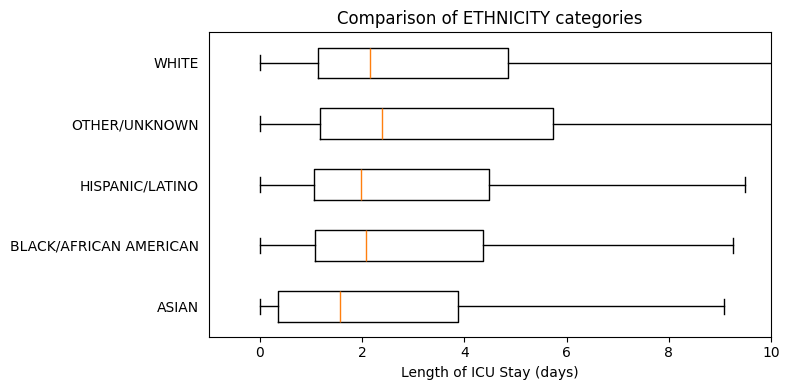

In [ ]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    '''
    Plot Median LOS by df categorical series name
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False)
    ax.set_title('Comparison of {} labels'.format(variable))

    plt.tight_layout()
    plt.show();

# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 10), size=(8,4)):
    '''
    Boxplot of LOS by df categorical series name
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of ICU Stay (days)')
    ax.tick_params(left=False, right=False)
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ETHNICITY', los_range=(-1, 10))

In [ ]:
df['RELIGION'].value_counts()

,count
RELIGION,
CATHOLIC,20136
NOT SPECIFIED,11539
UNOBTAINABLE,8151
PROTESTANT QUAKER,6961
JEWISH,5207
OTHER,2644
EPISCOPALIAN,754
GREEK ORTHODOX,451
CHRISTIAN SCIENTIST,420


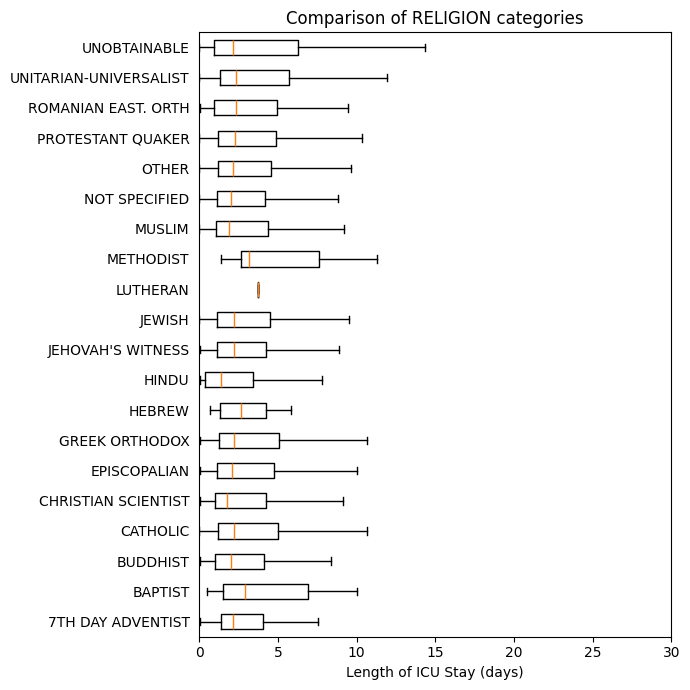

In [ ]:
boxplot_los_groupby('RELIGION', los_range=(0, 30), size=(7, 7))

In [ ]:
# Reduce categories to terms of religious or not
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGION
RELIGIOUS        38086
NOT SPECIFIED    11539
UNOBTAINABLE      8151
Name: count, dtype: int64
0.659201052340072
0.199719606757131
0.141079340902797


<ipython-input-23-227768edecd8>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'
<ipython-input-23-227768edecd8>:6: FutureWarning: Series.__getitem__ t

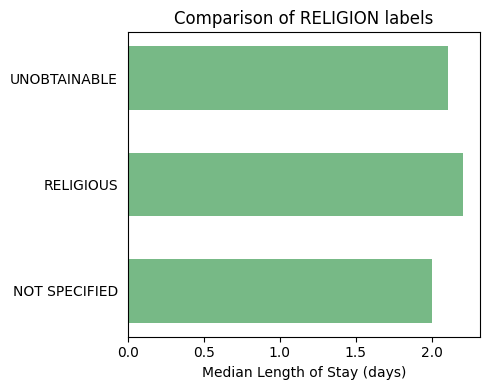

In [ ]:
# Look at median LOS for groups
plot_los_groupby('RELIGION', size=(5,4))

In [ ]:
df['ADMISSION_TYPE'].value_counts()

,count
ADMISSION_TYPE,
EMERGENCY,41653
NEWBORN,7763
ELECTIVE,7053
URGENT,1307


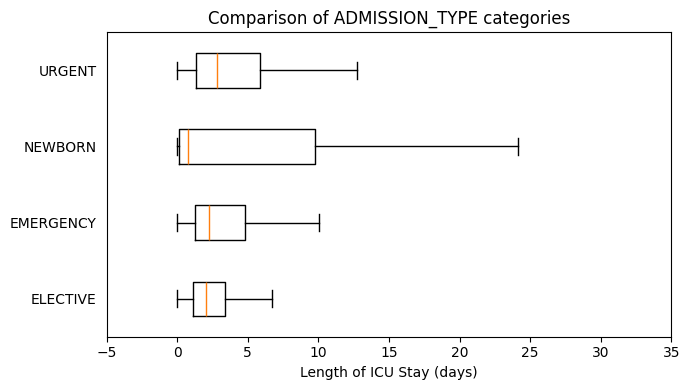

In [ ]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

In [ ]:
df['INSURANCE'].value_counts()

,count
INSURANCE,
Medicare,27640
Private,22090
Medicaid,5682
Government,1758
Self Pay,606


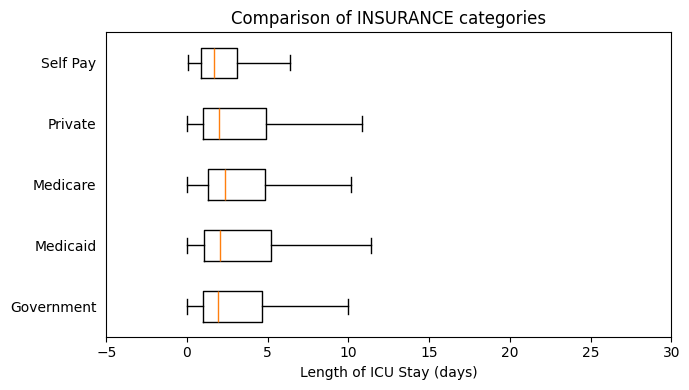

In [ ]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

In [ ]:
df['MARITAL_STATUS'].value_counts(dropna=False)

,count
MARITAL_STATUS,
MARRIED,23682
SINGLE,12989
NaN,9983
WIDOWED,7069
DIVORCED,3136
SEPARATED,558
UNKNOWN (DEFAULT),344
LIFE PARTNER,15


In [ ]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

,count
MARITAL_STATUS,
MARRIED,23682
SINGLE,12989
UNKNOWN (DEFAULT),10327
WIDOWED,7069
DIVORCED,3136
SEPARATED,558
LIFE PARTNER,15


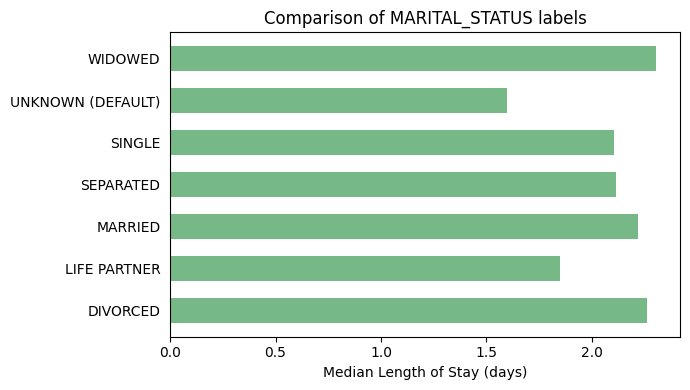

In [ ]:
plot_los_groupby('MARITAL_STATUS')

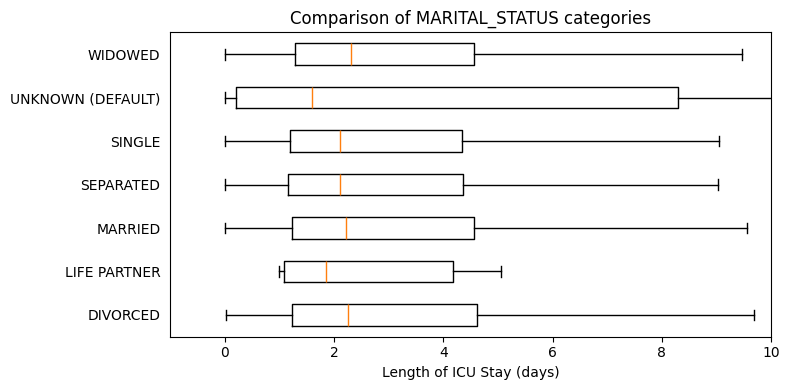

In [ ]:
boxplot_los_groupby('MARITAL_STATUS')

In [ ]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]),
            num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0], cat_range[1]),
                                     num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()

# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()

# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")

# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

df.head()

<ipython-input-33-6e5df621347c>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
<ipython-input-33-6e5df621347c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diagcode['recode'].fillna(value='999',

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED_IN_HOSPITAL,ICU_ADMISSION,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,2,163353,2138-07-17 19:04:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,UNKNOWN (DEFAULT),ASIAN,NEWBORN,0,1,0.0918,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
1,3,145834,2101-10-20 19:08:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,HYPOTENSION,0,1,6.0646,0,4,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1
2,4,185777,2191-03-16 00:28:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,RELIGIOUS,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,1.6785,0,0,0,1,1,0,3,2,0,2,0,0,0,0,0,0,0
3,5,178980,2103-02-02 04:31:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,RELIGIOUS,UNKNOWN (DEFAULT),ASIAN,NEWBORN,0,1,0.0844,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
4,6,107064,2175-05-30 07:15:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,3.6729,1,2,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Comparison of Diagnoses')

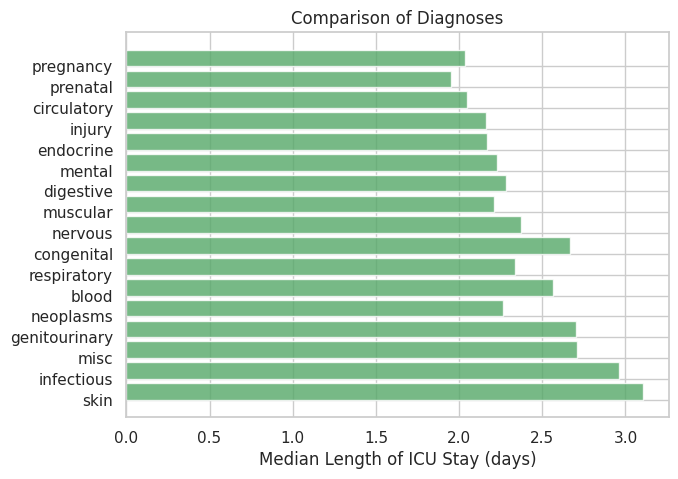

In [ ]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory',
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of ICU Stay (days)')
ax.tick_params(left=False, right=False, top=False)
ax.set_title('Comparison of Diagnoses'.format(variable))

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED_IN_HOSPITAL,ICU_ADMISSION,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,2,163353,2138-07-17 19:04:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,UNKNOWN (DEFAULT),ASIAN,NEWBORN,0,1,0.0918,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
1,3,145834,2101-10-20 19:08:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,HYPOTENSION,0,1,6.0646,0,4,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1
2,4,185777,2191-03-16 00:28:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,RELIGIOUS,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,1.6785,0,0,0,1,1,0,3,2,0,2,0,0,0,0,0,0,0
3,5,178980,2103-02-02 04:31:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,RELIGIOUS,UNKNOWN (DEFAULT),ASIAN,NEWBORN,0,1,0.0844,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
4,6,107064,2175-05-30 07:15:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,3.6729,1,2,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0


In [ ]:
list(df)

['SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DEATHTIME',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'DIAGNOSIS',
 'DECEASED_IN_HOSPITAL',
 'ICU_ADMISSION',
 'LOS',
 'blood',
 'circulatory',
 'congenital',
 'digestive',
 'endocrine',
 'genitourinary',
 'infectious',
 'injury',
 'mental',
 'misc',
 'muscular',
 'neoplasms',
 'nervous',
 'pregnancy',
 'prenatal',
 'respiratory',
 'skin']

In [ ]:
# Load patient data and merge with main df
df_pat['GENDER'].value_counts()

# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED_IN_HOSPITAL,ICU_ADMISSION,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER
0,2,163353,2138-07-17 19:04:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,UNKNOWN (DEFAULT),ASIAN,NEWBORN,0,1,0.0918,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2138-07-17,M
1,3,145834,2101-10-20 19:08:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,HYPOTENSION,0,1,6.0646,0,4,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,2025-04-11,M
2,4,185777,2191-03-16 00:28:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,RELIGIOUS,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,1.6785,0,0,0,1,1,0,3,2,0,2,0,0,0,0,0,0,0,2143-05-12,F
3,5,178980,2103-02-02 04:31:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,RELIGIOUS,UNKNOWN (DEFAULT),ASIAN,NEWBORN,0,1,0.0844,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2103-02-02,M
4,6,107064,2175-05-30 07:15:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,3.6729,1,2,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0,2109-06-21,F


In [ ]:
# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [ ]:
list(df_age_min)

['SUBJECT_ID', 'ADMIT_MIN']

In [ ]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [ ]:
# Calculate age and filter unrealistic ages
df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date
df['DOB'] = pd.to_datetime(df['DOB']).dt.date
df['age'] = df.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days/365, axis=1)
# Convert the 'age' column to numeric, setting errors='coerce' to handle non-numeric values
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Now drop rows where age is greater than 150
df = df[df['age'] <= 150]

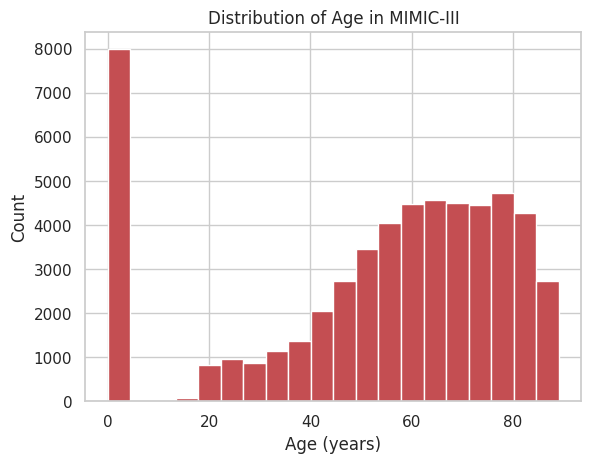

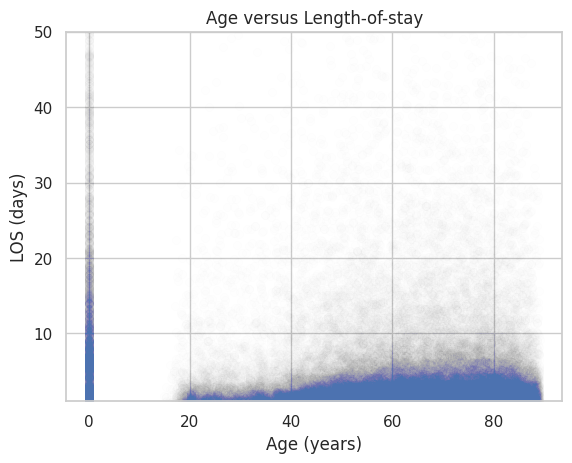

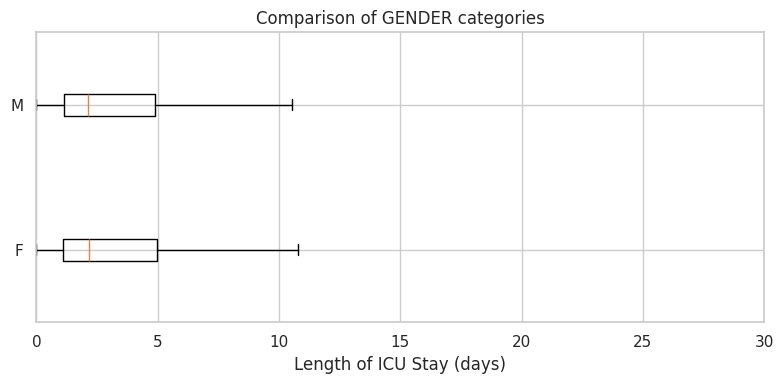

<ipython-input-42-2f40e8355b74>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
<ipython-input-42-2f40e8355b74>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)


In [ ]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show();

plt.scatter(df['age'], df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]),
            num, df['age'])

age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

boxplot_los_groupby('GENDER', los_range=(0, 30))
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55195 entries, 0 to 57775
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            55195 non-null  int64         
 1   HADM_ID               55195 non-null  int64         
 2   ADMITTIME             55195 non-null  datetime64[ns]
 3   DEATHTIME             5263 non-null   datetime64[ns]
 4   ADMISSION_TYPE        55195 non-null  object        
 5   ADMISSION_LOCATION    55195 non-null  object        
 6   DISCHARGE_LOCATION    55195 non-null  object        
 7   INSURANCE             55195 non-null  object        
 8   LANGUAGE              31257 non-null  object        
 9   RELIGION              55195 non-null  object        
 10  MARITAL_STATUS        55195 non-null  object        
 11  ETHNICITY             55195 non-null  object        
 12  DIAGNOSIS             55194 non-null  object        
 13  DECEASED_IN_HOSPITAL 

In [ ]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

df_icu['HADM_ID'].nunique()

df_icu.groupby('FIRST_CAREUNIT').median(numeric_only=True)

# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

df_icu['FIRST_CAREUNIT'].value_counts()

# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()


print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

df.head()

<ipython-input-44-da8b0e459270>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',


<class 'pandas.core.frame.DataFrame'>
Index: 61532 entries, 365 to 59810
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SUBJECT_ID      61532 non-null  int64  
 1   HADM_ID         61532 non-null  int64  
 2   ICUSTAY_ID      61532 non-null  int64  
 3   DBSOURCE        61532 non-null  object 
 4   FIRST_CAREUNIT  61532 non-null  object 
 5   LAST_CAREUNIT   61532 non-null  object 
 6   FIRST_WARDID    61532 non-null  int64  
 7   LAST_WARDID     61532 non-null  int64  
 8   INTIME          61532 non-null  object 
 9   OUTTIME         61522 non-null  object 
 10  LOS             61522 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 5.6+ MB
Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED_IN_HOSPITAL,ICU_ADMISSION,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN,age,ICU,NICU
0,58526.0,100001,2117-09-11 11:46:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,RELIGIOUS,DIVORCED,WHITE,DIABETIC KETOACIDOSIS,0.0,1.0,4.2567,0.0,2.0,0.0,2.0,5.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2082-03-21,1.0,2117-09-11,young_adult,1,0
1,54610.0,100003,2150-04-17 15:34:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,UPPER GI BLEED,0.0,1.0,1.9425,1.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2090-05-19,0.0,2150-04-17,senior,1,0
2,9895.0,100006,2108-04-06 15:49:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,COPD FLARE,0.0,1.0,4.9776,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,2059-05-07,1.0,2108-04-06,middle_adult,1,0
3,23018.0,100007,2145-03-31 05:33:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,RELIGIOUS,MARRIED,WHITE,BOWEL OBSTRUCTION,0.0,1.0,4.0998,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2071-06-04,1.0,2145-03-31,senior,1,0
4,533.0,100009,2162-05-16 15:56:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Private,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE,0.0,1.0,2.4908,1.0,7.0,0.0,0.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2101-07-30,0.0,2162-05-16,senior,1,0


In [ ]:
df.info()
df['DECEASED_IN_HOSPITAL'] = df['DECEASED_IN_HOSPITAL'].fillna(0).astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57786 entries, 0 to 57785
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            55195 non-null  float64       
 1   HADM_ID               57786 non-null  int64         
 2   ADMITTIME             55195 non-null  datetime64[ns]
 3   DEATHTIME             5263 non-null   datetime64[ns]
 4   ADMISSION_TYPE        55195 non-null  object        
 5   ADMISSION_LOCATION    55195 non-null  object        
 6   DISCHARGE_LOCATION    55195 non-null  object        
 7   INSURANCE             55195 non-null  object        
 8   LANGUAGE              31257 non-null  object        
 9   RELIGION              55195 non-null  object        
 10  MARITAL_STATUS        55195 non-null  object        
 11  ETHNICITY             55195 non-null  object        
 12  DIAGNOSIS             55194 non-null  object        
 13  DECEASED_IN_HOSP

In [ ]:
# Replace NaNs with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)


# Verify NaN fix
print(df.ICU.value_counts(dropna=False))
print(df.NICU.value_counts(dropna=False))

# Look at what is no longer needed in the DataFrame
df.info()

# Remove LOS with negative number, likely entry form error
df = df[df['LOS'] > 0]



ICU
1    49794
0     7992
Name: count, dtype: int64
NICU
0    49794
1     7992
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57786 entries, 0 to 57785
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            55195 non-null  float64       
 1   HADM_ID               57786 non-null  int64         
 2   ADMITTIME             55195 non-null  datetime64[ns]
 3   DEATHTIME             5263 non-null   datetime64[ns]
 4   ADMISSION_TYPE        55195 non-null  object        
 5   ADMISSION_LOCATION    55195 non-null  object        
 6   DISCHARGE_LOCATION    55195 non-null  object        
 7   INSURANCE             55195 non-null  object        
 8   LANGUAGE              31257 non-null  object        
 9   RELIGION              55195 non-null  object        
 10  MARITAL_STATUS        55195 non-null  object        
 11  ETHNICITY             55195

<ipython-input-46-4e806cfe2bb6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ICU'].fillna(value=0, inplace=True)
<ipython-input-46-4e806cfe2bb6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

In [ ]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

# Verify
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 55195 entries, 0 to 57785
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   SUBJECT_ID                  55195 non-null  float64       
 1   HADM_ID                     55195 non-null  int64         
 2   ADMITTIME                   55195 non-null  datetime64[ns]
 3   DEATHTIME                   5263 non-null   datetime64[ns]
 4   ADMISSION_LOCATION          55195 non-null  object        
 5   DISCHARGE_LOCATION          55195 non-null  object        
 6   LANGUAGE                    31257 non-null  object        
 7   DIAGNOSIS                   55194 non-null  object        
 8   DECEASED_IN_HOSPITAL        55195 non-null  int64         
 9   ICU_ADMISSION               55195 non-null  float64       
 10  LOS                         55195 non-null  float64       
 11  blood                       55195 non-null  float64       


# **Text Preprocessing of Discharge Summary**

In [ ]:
# Filter and merge discharge summary
df_notes_dis_sum = df_discharge_summary.loc[df_discharge_summary.CATEGORY == 'Discharge summary']
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'
df = pd.merge(df, df_notes_dis_sum_last[['SUBJECT_ID', 'HADM_ID', 'TEXT']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [ ]:
# Drop unused or no longer needed columns
df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DEATHTIME'], inplace=True)

In [ ]:
len(df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55195 entries, 0 to 55194
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DECEASED_IN_HOSPITAL        55195 non-null  int64  
 1   ICU_ADMISSION               55195 non-null  float64
 2   LOS                         55195 non-null  float64
 3   blood                       55195 non-null  float64
 4   circulatory                 55195 non-null  float64
 5   congenital                  55195 non-null  float64
 6   digestive                   55195 non-null  float64
 7   endocrine                   55195 non-null  float64
 8   genitourinary               55195 non-null  float64
 9   infectious                  55195 non-null  float64
 10  injury                      55195 non-null  float64
 11  mental                      55195 non-null  float64
 12  misc                        55195 non-null  float64
 13  muscular                    551

In [ ]:
# Preprocess text data
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

# Tokenize text data
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words

    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

df_dis_sum = preprocess_text(df)

my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x', 'q', 'no', 'ml', 'po', 'mg', 'md', 'hd', 'it', 'm', 'dm', 'cm', 'osh', 'rca', 'mcg', 'esrd']

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000,
                       tokenizer = tokenizer_better,
                       stop_words = my_stop_words)

# Fit and transform the text data
df_dis_sum_vect_values = vect.fit_transform(df_dis_sum.TEXT.values)

# Transform the sparse matrix to a DataFrame if needed
df_features = pd.DataFrame(df_dis_sum_vect_values.toarray(), columns=vect.get_feature_names_out())

# Concatenate with the original DataFrame
df = pd.concat([df_dis_sum.reset_index(drop=True), df_features], axis=1)

# Drop unused or no longer needed columns
df.drop(columns=['TEXT'], inplace=True)

print(df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


   DECEASED_IN_HOSPITAL  ICU_ADMISSION     LOS  blood  circulatory  \
0                     0            1.0  4.2567    0.0          2.0   
1                     0            1.0  1.9425    1.0          2.0   
2                     0            1.0  4.9776    0.0          0.0   
3                     0            1.0  4.0998    0.0          1.0   
4                     0            1.0  2.4908    1.0          7.0   

   congenital  digestive  endocrine  genitourinary  infectious  injury  \
0         0.0        2.0        5.0            2.0         0.0     2.0   
1         0.0        4.0        0.0            0.0         1.0     0.0   
2         0.0        0.0        1.0            0.0         0.0     2.0   
3         0.0        2.0        0.0            0.0         0.0     1.0   
4         0.0        0.0        3.0            0.0         0.0     7.0   

   mental  misc  muscular  neoplasms  nervous  pregnancy  prenatal  \
0     0.0   0.0       0.0        0.0      2.0        0.0       0

# **Machine Learning Model Training and Evaluation**

In [ ]:
# Target Variable (DECEASED_IN_HOSPITAL)
target = df['DECEASED_IN_HOSPITAL'].values

# Prediction Features
features = df.drop(columns=['DECEASED_IN_HOSPITAL'])

#Convert to dense matrix
features = features.to_numpy()

# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

# Classification models for comparison
models = [
    RandomForestClassifier(random_state=0),
    KNeighborsClassifier(),
    XGBClassifier(eval_metric='auc', random_state=0, enable_categorical=True)
]

results = {}

for model in models:
    # Instantiate and fit Classifier Model
    clf_model = model
    clf_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = clf_model.predict(X_test)
    y_test_probs = clf_model.predict_proba(X_test)[:, 1]

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_preds)
    precision = precision_score(y_test, y_test_preds)
    recall = recall_score(y_test, y_test_preds)
    auc = roc_auc_score(y_test, y_test_probs)

    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'AUC': auc}
    print('{} done.'.format(name))

# Print results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Training set has 44156 samples.
Testing set has 11039 samples.
RandomForestClassifier done.
KNeighborsClassifier done.
XGBClassifier done.

RandomForestClassifier Results:
Accuracy: 0.9839
Precision: 0.9737
Recall: 0.8579
AUC: 0.9970

KNeighborsClassifier Results:
Accuracy: 0.9596
Precision: 0.8311
Recall: 0.7354
AUC: 0.9467

XGBClassifier Results:
Accuracy: 0.9893
Precision: 0.9528
Recall: 0.9369
AUC: 0.9972


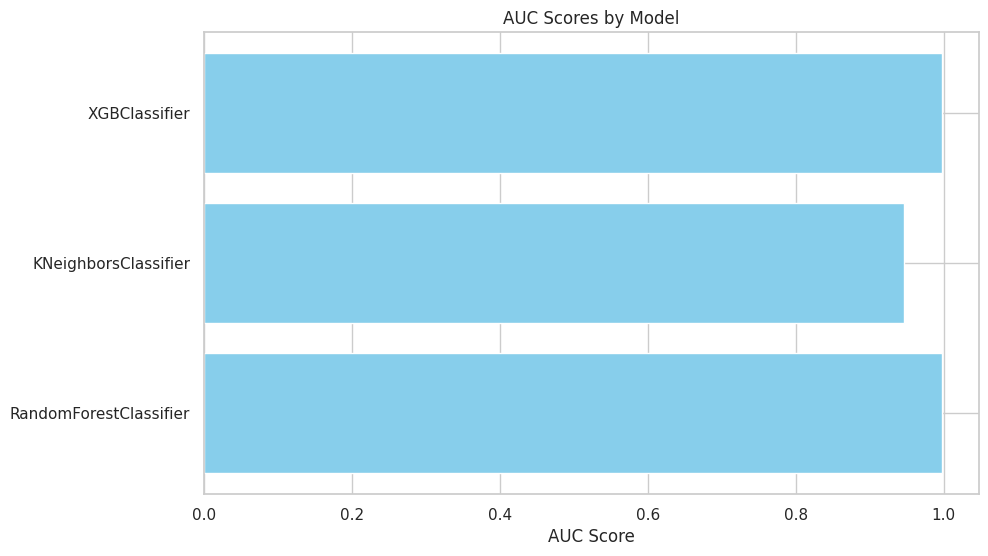

In [ ]:
# Extract AUC scores for plotting
auc_scores = [metrics['AUC'] for metrics in results.values()] # Create a list of AUC scores from the results dictionary

# Plot AUC scores
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), auc_scores, color='skyblue') # Use the created auc_scores list
plt.xlabel('AUC Score')
plt.title('AUC Scores by Model')
plt.show()

In [ ]:
# Hyperparameter tuning with GridSearchCV for XGBoost
tuned_parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(XGBClassifier(eval_metric='auc', random_state=0, enable_categorical=True), tuned_parameters, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
clf_optimized = grid.best_estimator_

# Summarize the results of the grid search
print("Best AUC score from GridSearchCV: {:.4f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

# Evaluate the optimized model
y_test_preds_optimized = clf_optimized.predict(X_test)
y_test_probs_optimized = clf_optimized.predict_proba(X_test)[:, 1]
auc_score_optimized = roc_auc_score(y_test, y_test_probs_optimized)
print("Optimized AUC score is: {:.4f}".format(auc_score_optimized))


Best AUC score from GridSearchCV: 0.9960
Best parameters:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Optimized AUC score is: 0.9977


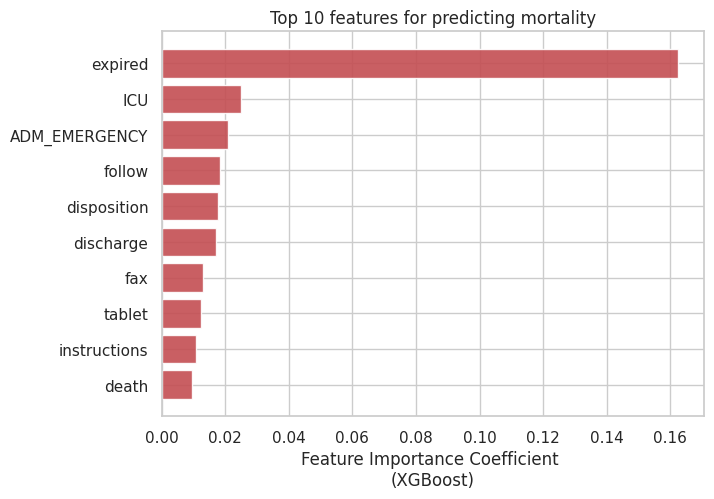

In [ ]:
# Feature importance
features = df.drop(columns=['DECEASED_IN_HOSPITAL'])
feature_names = features.columns
feature_imp = pd.DataFrame(clf_optimized.feature_importances_, index=feature_names, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(10)
ax.barh(ind, feature_imp['importance'].values[:10], align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[:10].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 10 features for predicting mortality")
ax.set_xlabel('Feature Importance Coefficient \n(XGBoost)')
plt.gca().invert_yaxis()
plt.show()